## Importing necessary libs

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score

from catboost import CatBoostRegressor
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import seaborn as sns

## Preparing features and labels

In [2]:
df = pd.read_csv("fe_data.csv")
df = df.drop("userID_anonymized", 1) # since it's not a feature and we need number indexes in CV

## Setting categorical columns
df["model"] = df["model"].astype("category")
df["operating_system"] = df["operating_system"].astype("category")

Xs = df.drop("totalrevenue", 1) # extracting label
ys = df["totalrevenue"] # defining label

In [3]:
Xs.head()

,mean_revenue_banner_impression,mean_revenue_interstitial_impression,mean_revenue_level_event,mean_revenue_rewarded_impression,std_revenue_banner_impression,std_revenue_interstitial_impression,std_revenue_level_event,std_revenue_rewarded_impression,total_count_banner_impression,total_count_interstitial_impression,...,total_count_rewarded_impression,last_time_banner_impression,last_time_interstitial_impression,last_time_level_event,last_time_rewarded_impression,model,operating_system,mean_wifi_state,last_session_no,last_level
0,0.000400,0.030000,0.0,0.00,0.000000,0.000000,0.0,0.0,6,1,...,0,13.0,2.0,14.0,0.0,"iPhone8,2",iOS 14.0.1,1.000000,3,65
1,0.000375,0.030000,0.0,0.00,0.000318,0.000000,0.0,0.0,2,1,...,0,0.0,0.0,0.0,0.0,"iPhone12,1",iOS 14.2,1.000000,1,4
2,0.000669,0.027517,0.0,0.04,0.000962,0.005541,0.0,0.0,118,30,...,2,4078.0,4076.0,4078.0,1621.0,"iPhone12,8",iOS 14.1,0.814159,8,1004
3,0.000416,0.022920,0.0,0.04,0.000184,0.005129,0.0,0.0,82,25,...,1,5137.0,5136.0,5137.0,763.0,"iPhone9,3",iOS 13.7,1.000000,5,1003
4,0.000537,0.030000,0.0,0.00,0.000096,0.003536,0.0,0.0,16,5,...,0,2368.0,2035.0,2369.0,0.0,"iPhone10,2",iOS 14.2,1.000000,4,67


In [4]:
ys.head()

0    0.032400
1    0.030750
2    1.211006
3    0.881707
4    0.184700
Name: totalrevenue, dtype: float64

## Train-Test Splitting 

In [5]:
X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=0.2, random_state=1773)

## Defining the Regressor

In [6]:
params = {'bootstrap_type': 'Bernoulli',
 'colsample_bylevel': 0.85,
 'depth': 4,
 'eval_metric': 'MAPE',
 'fold_len_multiplier': 1.5250180256158454,
 'grow_policy': 'Lossguide',
 'l2_leaf_reg': 6.827754494022499,
 'leaf_estimation_backtracking': 'No',
 'learning_rate': 0.0864786151724121,
 'max_leaves': 30,
 'min_data_in_leaf': 38,
 'random_strength': 0.005797093316392755}

clf = CatBoostRegressor(**params,
                        cat_features=[16,17],
                        objective="MAPE",
                        task_type="CPU")

## Predicting with K-Fold CV

In [7]:
cv = KFold(n_splits=5, random_state=1773, shuffle=True)

preds_for_subm = []

mae_scores = []
mape_scores = []
feat_imps = []

for fold_id, (train_ix, test_ix) in enumerate(cv.split(X_train, y=y_train)):

    train_X, val_X = X_train.iloc[train_ix], X_train.iloc[test_ix]
    train_y, val_y = y_train.iloc[train_ix], y_train.iloc[test_ix]
    
    clf.fit(train_X, train_y, eval_set=(val_X, val_y), early_stopping_rounds=150, verbose=False)
    yhat = clf.predict(val_X)
    
    mae = abs(val_y - yhat).mean()
    mae_scores.append(mae)
    
    mape = (abs(val_y - yhat)/val_y).mean()
    mape_scores.append(mape)    
    
    yhat_subm = clf.predict(X_test)
    preds_for_subm.append(yhat_subm)
    
    feat_imps.append(clf.get_feature_importance())
    
    print('RESULTS >> Fold', fold_id+1, "|| MAE:", np.round(mae,3), "|| MAPE:", np.round(mape,3))

RESULTS >> Fold 1 || MAE: 0.079 || MAPE: 0.344
RESULTS >> Fold 2 || MAE: 0.088 || MAPE: 0.296
RESULTS >> Fold 3 || MAE: 0.085 || MAPE: 0.293
RESULTS >> Fold 4 || MAE: 0.087 || MAPE: 0.288
RESULTS >> Fold 5 || MAE: 0.08 || MAPE: 0.548


### CV Results

In [8]:
mean_mae, std_mae = np.mean(mae_scores), np.std(mae_scores)
print('Mean MAE: %.3f, Standard Deviation: %.3f' % (mean_mae, std_mae))

mean_mape, std_mape = np.mean(mape_scores), np.std(mape_scores)
print('Mean MAPE: %.3f, Standard Deviation: %.3f' % (mean_mape, std_mape))

Mean MAE: 0.084, Standard Deviation: 0.004
Mean MAPE: 0.354, Standard Deviation: 0.099


# Test Set Scores

In [9]:
preds_for_subm_arr = np.array(preds_for_subm)
preds_for_subm_arr = preds_for_subm_arr.mean(axis=0)

In [10]:
print("Test MAE:", np.round(abs(y_test - preds_for_subm_arr).mean(),3))
print("Test MAPE:", np.round((abs(y_test - preds_for_subm_arr)/y_test).mean(),3))
print()
print("Test MAE-std:", np.round(abs(y_test - preds_for_subm_arr).std(),3))
print("Test MAPE-std:", np.round((abs(y_test - preds_for_subm_arr)/y_test).std(),3))

Test MAE: 0.083
Test MAPE: 0.215

Test MAE-std: 0.183
Test MAPE-std: 0.587


## Feature Importances

In [11]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' Feature Importances')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Name')

In [12]:
feat_imps = np.array(feat_imps)
mean_feat_imps = feat_imps.mean(axis=0)

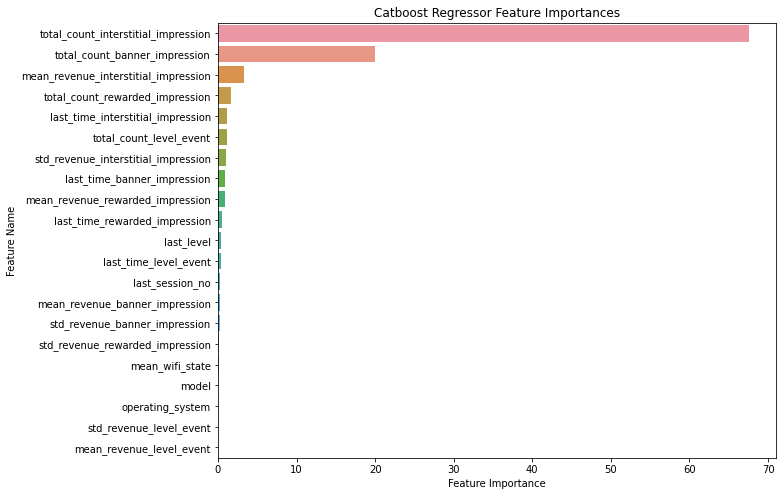

In [13]:
plot_feature_importance(mean_feat_imps,X_train.columns,'Catboost Regressor')

## Prune the data (only important features)

In [14]:
df = df[["total_count_interstitial_impression","total_count_banner_impression","total_count_rewarded_impression",\
         "total_count_level_event", "mean_revenue_interstitial_impression", "last_time_interstitial_impression",\
         "mean_revenue_rewarded_impression", "last_time_banner_impression", "totalrevenue"]]

df.to_csv('pruned_df.csv', index=False) 